# Preprocessing Visualization Pipeline

This notebook generates all required plots and visualizations according to project requirements:

- **Skull stripping**: Before/after brain plots
- **Segmentation**: Tissue-segmented brain plot  
- **Motion correction**: Framewise displacement plot
- **Co-registration**: Overlay of source and target volumes
- **Gaussian smoothing**: Before/after brain plots


In [1]:
# Imports and setup
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from config import (
    T1W_PATH, DERIVATIVES_ROOT, OUTPUT_ROOT, RAW_DIR,
    MOCO_DIR, COREG_DIR, SMOOTH_DIR
)

# Set matplotlib to display plots inline
%matplotlib inline

# Ensure output directory exists
os.makedirs(os.path.join(OUTPUT_ROOT, "figures"), exist_ok=True)


In [2]:
def load_image_safely(path, description=""):
    """Load NIfTI image with error handling."""
    if not os.path.isfile(path):
        raise FileNotFoundError(f"{description} file not found: {path}")
    
    img = nib.load(path)
    print(f"Loaded {description}: {path} (shape: {img.shape})")
    return img


## 1. Skull Stripping Visualization

Report the brain plots before and after to visually assess the effect of this step.


Loaded Original T1w: ./subject101410/T1w/T1w.nii.gz (shape: (260, 311, 260))
Loaded Skull-stripped brain: ./derivatives/preprocessed_data/subject101410/T1w_brain.nii.gz (shape: (260, 311, 260))
Skull stripping comparison saved to: /local_temp/pivron/Project/output/figures/skull_stripping_comparison.png


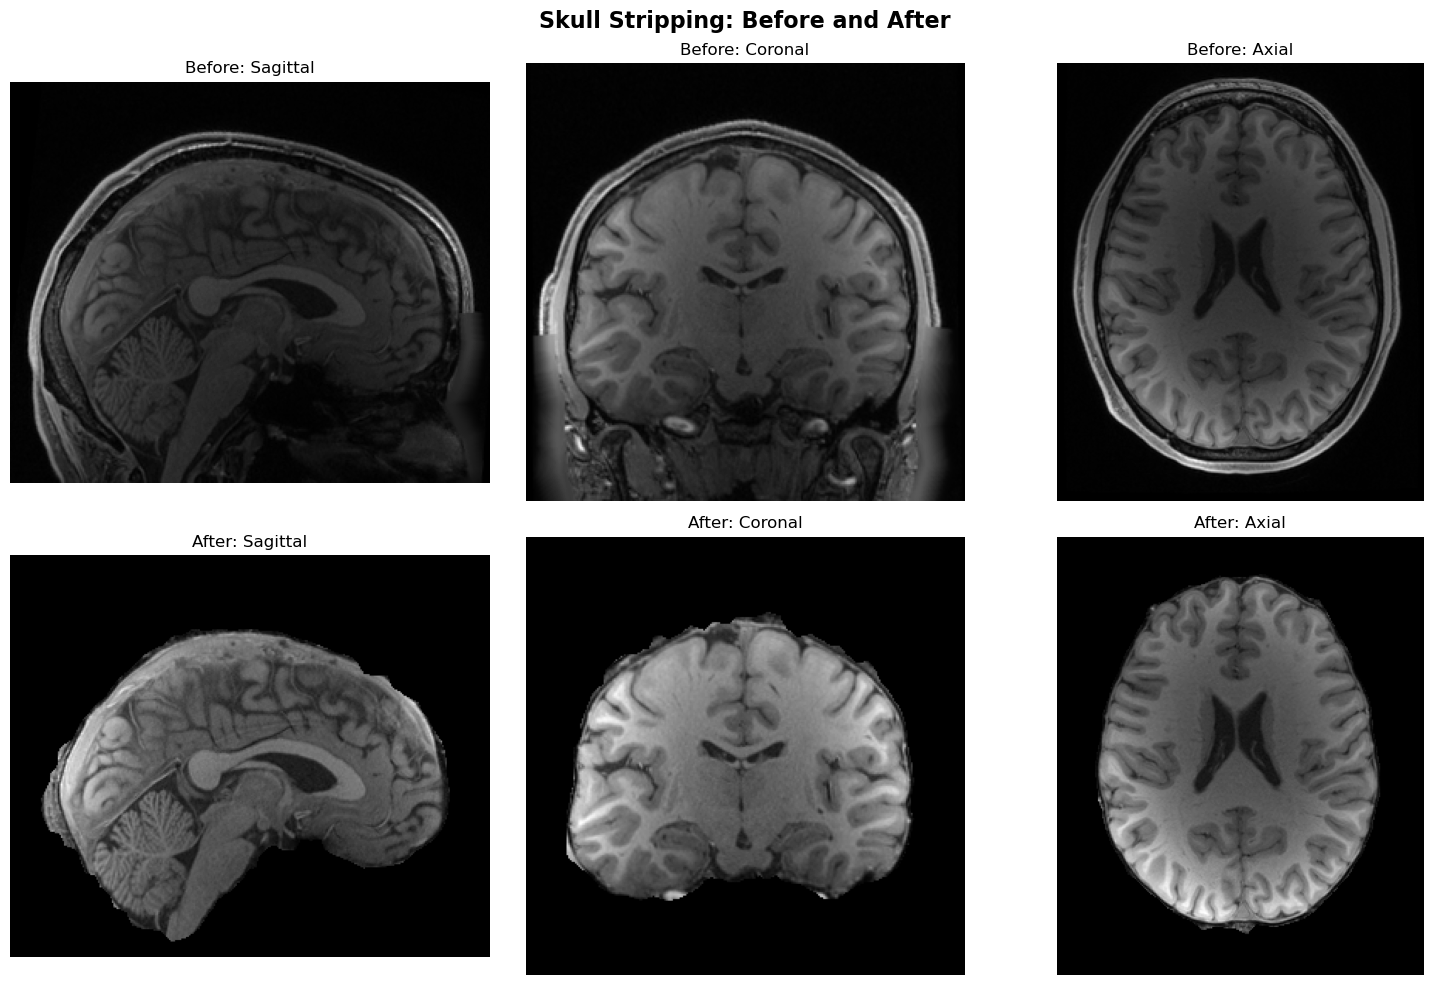

In [3]:
# Load images
original = load_image_safely(T1W_PATH, "Original T1w")
brain = load_image_safely(
    os.path.join(DERIVATIVES_ROOT, "T1w_brain.nii.gz"),
    "Skull-stripped brain"
)

# Extract middle slices for each view
original_data = original.get_fdata()
brain_data = brain.get_fdata()

# Create figure with before/after comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Skull Stripping: Before and After', fontsize=16, fontweight='bold')

# Sagittal view (middle x-slice)
mid_x = original_data.shape[0] // 2
axes[0, 0].imshow(original_data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Before: Sagittal')
axes[0, 0].axis('off')

axes[1, 0].imshow(brain_data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[1, 0].set_title('After: Sagittal')
axes[1, 0].axis('off')

# Coronal view (middle y-slice)
mid_y = original_data.shape[1] // 2
axes[0, 1].imshow(original_data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title('Before: Coronal')
axes[0, 1].axis('off')

axes[1, 1].imshow(brain_data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1, 1].set_title('After: Coronal')
axes[1, 1].axis('off')

# Axial view (middle z-slice)
mid_z = original_data.shape[2] // 2
axes[0, 2].imshow(original_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0, 2].set_title('Before: Axial')
axes[0, 2].axis('off')

axes[1, 2].imshow(brain_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[1, 2].set_title('After: Axial')
axes[1, 2].axis('off')

plt.tight_layout()

# Save figure
output_path = os.path.join(OUTPUT_ROOT, "figures", "skull_stripping_comparison.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Skull stripping comparison saved to: {output_path}")
plt.show()


## 2. Tissue Segmentation Visualization

Report on a brain plot the tissues segmented (CSF, Gray Matter, White Matter).


Loaded Skull-stripped brain: ./derivatives/preprocessed_data/subject101410/T1w_brain.nii.gz (shape: (260, 311, 260))
Loaded CSF: ./derivatives/preprocessed_data/subject101410/T1w_fast_pve_0.nii.gz (shape: (260, 311, 260))
Loaded Gray Matter: ./derivatives/preprocessed_data/subject101410/T1w_fast_pve_1.nii.gz (shape: (260, 311, 260))
Loaded White Matter: ./derivatives/preprocessed_data/subject101410/T1w_fast_pve_2.nii.gz (shape: (260, 311, 260))
Segmentation visualization saved to: /local_temp/pivron/Project/output/figures/segmentation.png


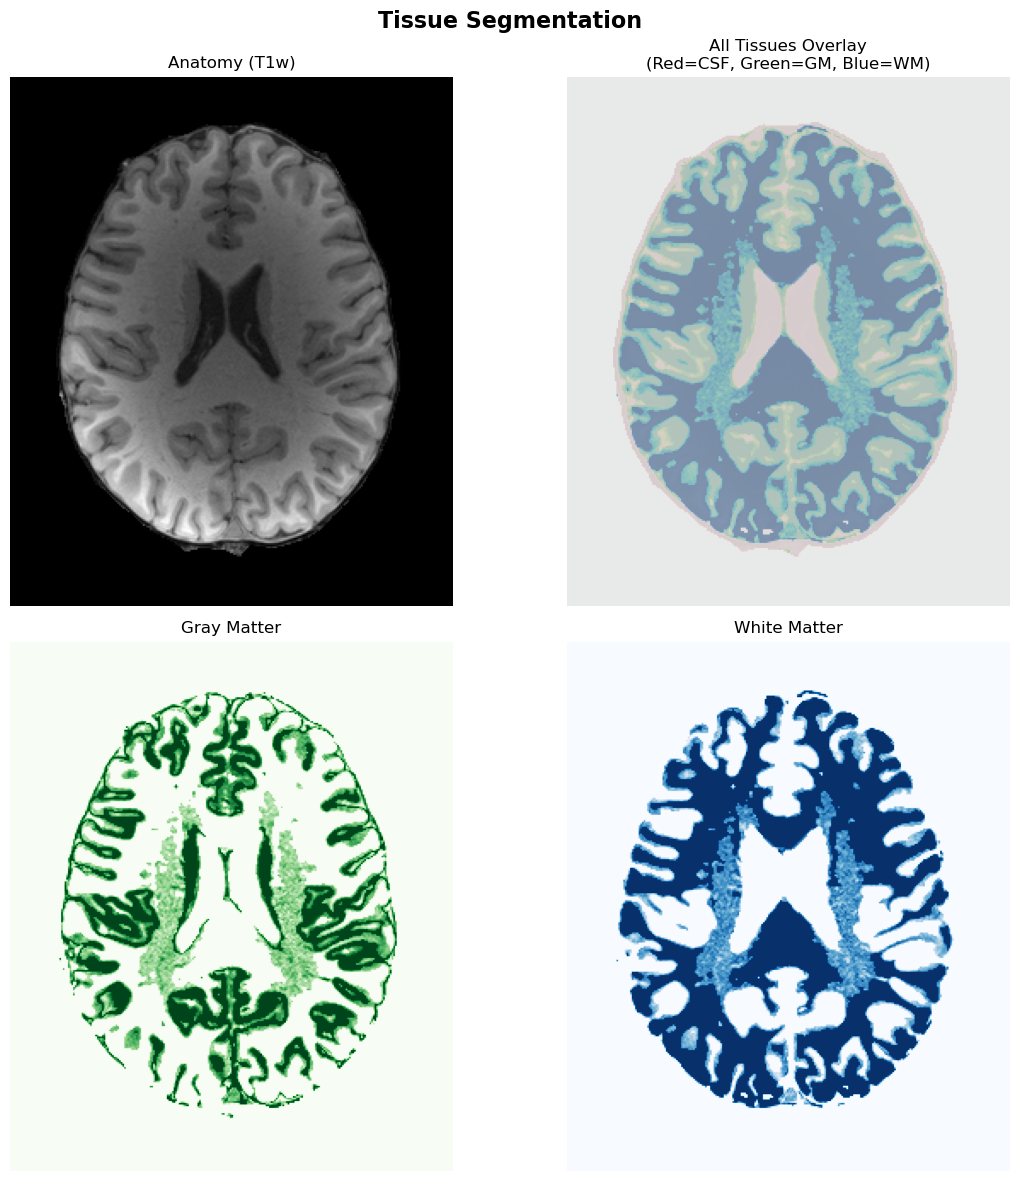

In [4]:
# Load images
brain = load_image_safely(
    os.path.join(DERIVATIVES_ROOT, "T1w_brain.nii.gz"),
    "Skull-stripped brain"
)
csf = load_image_safely(
    os.path.join(DERIVATIVES_ROOT, "T1w_fast_pve_0.nii.gz"),
    "CSF"
)
gm = load_image_safely(
    os.path.join(DERIVATIVES_ROOT, "T1w_fast_pve_1.nii.gz"),
    "Gray Matter"
)
wm = load_image_safely(
    os.path.join(DERIVATIVES_ROOT, "T1w_fast_pve_2.nii.gz"),
    "White Matter"
)

# Create overlay visualization
brain_data = brain.get_fdata()
csf_data = csf.get_fdata()
gm_data = gm.get_fdata()
wm_data = wm.get_fdata()

# Extract middle axial slice
mid_z = brain_data.shape[2] // 2

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Tissue Segmentation', fontsize=16, fontweight='bold')

# Brain anatomy
axes[0, 0].imshow(brain_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Anatomy (T1w)')
axes[0, 0].axis('off')

# Overlay all tissues
axes[0, 1].imshow(brain_data[:, :, mid_z].T, cmap='gray', origin='lower', alpha=0.5)
axes[0, 1].imshow(csf_data[:, :, mid_z].T, cmap='Reds', alpha=0.5, origin='lower')
axes[0, 1].imshow(gm_data[:, :, mid_z].T, cmap='Greens', alpha=0.5, origin='lower')
axes[0, 1].imshow(wm_data[:, :, mid_z].T, cmap='Blues', alpha=0.5, origin='lower')
axes[0, 1].set_title('All Tissues Overlay\n(Red=CSF, Green=GM, Blue=WM)')
axes[0, 1].axis('off')

# Individual tissues
axes[1, 0].imshow(gm_data[:, :, mid_z].T, cmap='Greens', origin='lower')
axes[1, 0].set_title('Gray Matter')
axes[1, 0].axis('off')

axes[1, 1].imshow(wm_data[:, :, mid_z].T, cmap='Blues', origin='lower')
axes[1, 1].set_title('White Matter')
axes[1, 1].axis('off')

plt.tight_layout()

# Save figure
output_path = os.path.join(OUTPUT_ROOT, "figures", "segmentation.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Segmentation visualization saved to: {output_path}")
plt.show()


## 3. Framewise Displacement Plot

Report the plot of the framewise displacement.


In [5]:
# Load motion parameters and compute FD
from MotionCorrection import load_motion_parameters, compute_framewise_displacement, compute_fd_threshold
from config import FD_RADIUS_MM

par_path = os.path.join(MOCO_DIR, "moco.par")
if not os.path.isfile(par_path):
    raise FileNotFoundError(f"Motion parameters not found: {par_path}")

mot_params = load_motion_parameters(par_path, dof=6)
fd = compute_framewise_displacement(mot_params, radius_mm=FD_RADIUS_MM)
threshold = compute_fd_threshold(fd, method='iqr')

print(f"Framewise Displacement Statistics:")
print(f"  Mean FD: {np.mean(fd):.3f} mm")
print(f"  Median FD: {np.median(fd):.3f} mm")
print(f"  Max FD: {np.max(fd):.3f} mm")
print(f"  Threshold (IQR method): {threshold:.3f} mm")
print(f"  Volumes > threshold: {np.sum(fd > threshold)} ({100*np.sum(fd > threshold)/len(fd):.1f}%)")


Framewise Displacement Statistics:
  Mean FD: 0.072 mm
  Median FD: 0.041 mm
  Max FD: 1.194 mm
  Threshold (IQR method): 0.125 mm
  Volumes > threshold: 93 (16.4%)


Framewise displacement plot saved to: /local_temp/pivron/Project/output/figures/framewise_displacement.png


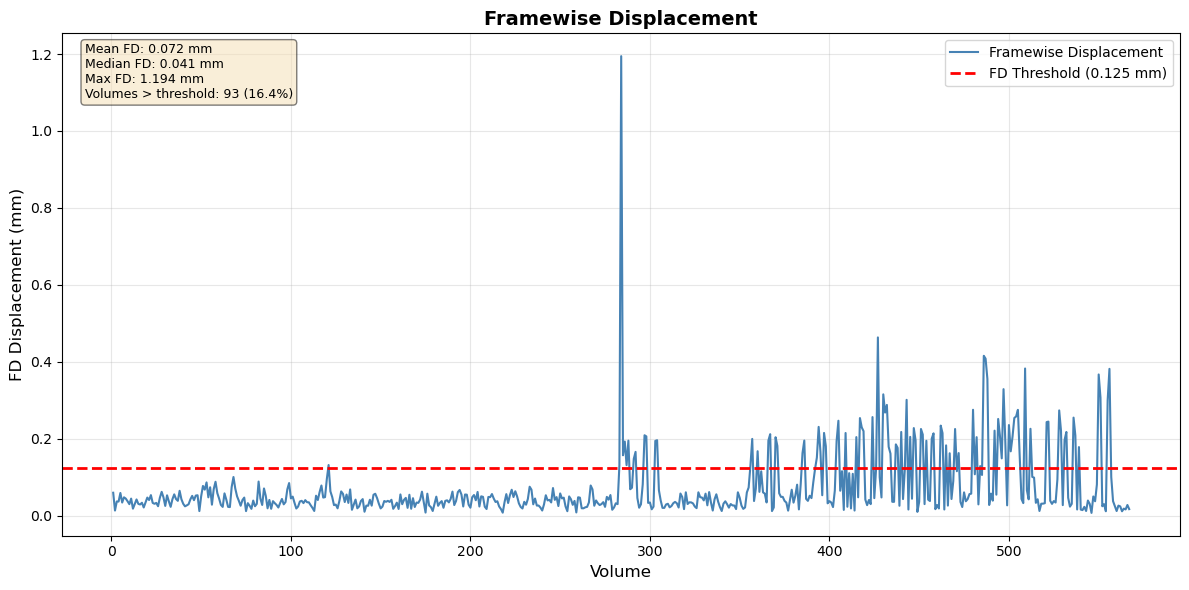

In [6]:
# Plot framewise displacement
fig, ax = plt.subplots(figsize=(12, 6))

volumes = np.arange(1, len(fd) + 1)
ax.plot(volumes, fd, linewidth=1.5, label='Framewise Displacement', color='steelblue')
ax.axhline(
    y=threshold,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'FD Threshold ({threshold:.3f} mm)'
)

ax.set_xlabel('Volume', fontsize=12)
ax.set_ylabel('FD Displacement (mm)', fontsize=12)
ax.set_title('Framewise Displacement', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add statistics text
stats_text = (
    f'Mean FD: {np.mean(fd):.3f} mm\n'
    f'Median FD: {np.median(fd):.3f} mm\n'
    f'Max FD: {np.max(fd):.3f} mm\n'
    f'Volumes > threshold: {np.sum(fd > threshold)} ({100*np.sum(fd > threshold)/len(fd):.1f}%)'
)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
output_path = os.path.join(OUTPUT_ROOT, "figures", "framewise_displacement.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Framewise displacement plot saved to: {output_path}")
plt.show()


## 4. Co-registration Visualization

Report a brain plot overlaying the source and the target volume.  
Note: This step is for visualization only and results are not used in the rest of the preprocessing pipeline.


Loaded T1w brain (target): ./derivatives/preprocessed_data/subject101410/T1w_brain.nii.gz (shape: (260, 311, 260))
Loaded Registered EPI (source): /local_temp/pivron/Project/output/coreg/moco_vol_bbr.nii.gz (shape: (260, 311, 260))
Co-registration visualization saved to: /local_temp/pivron/Project/output/figures/coregistration.png


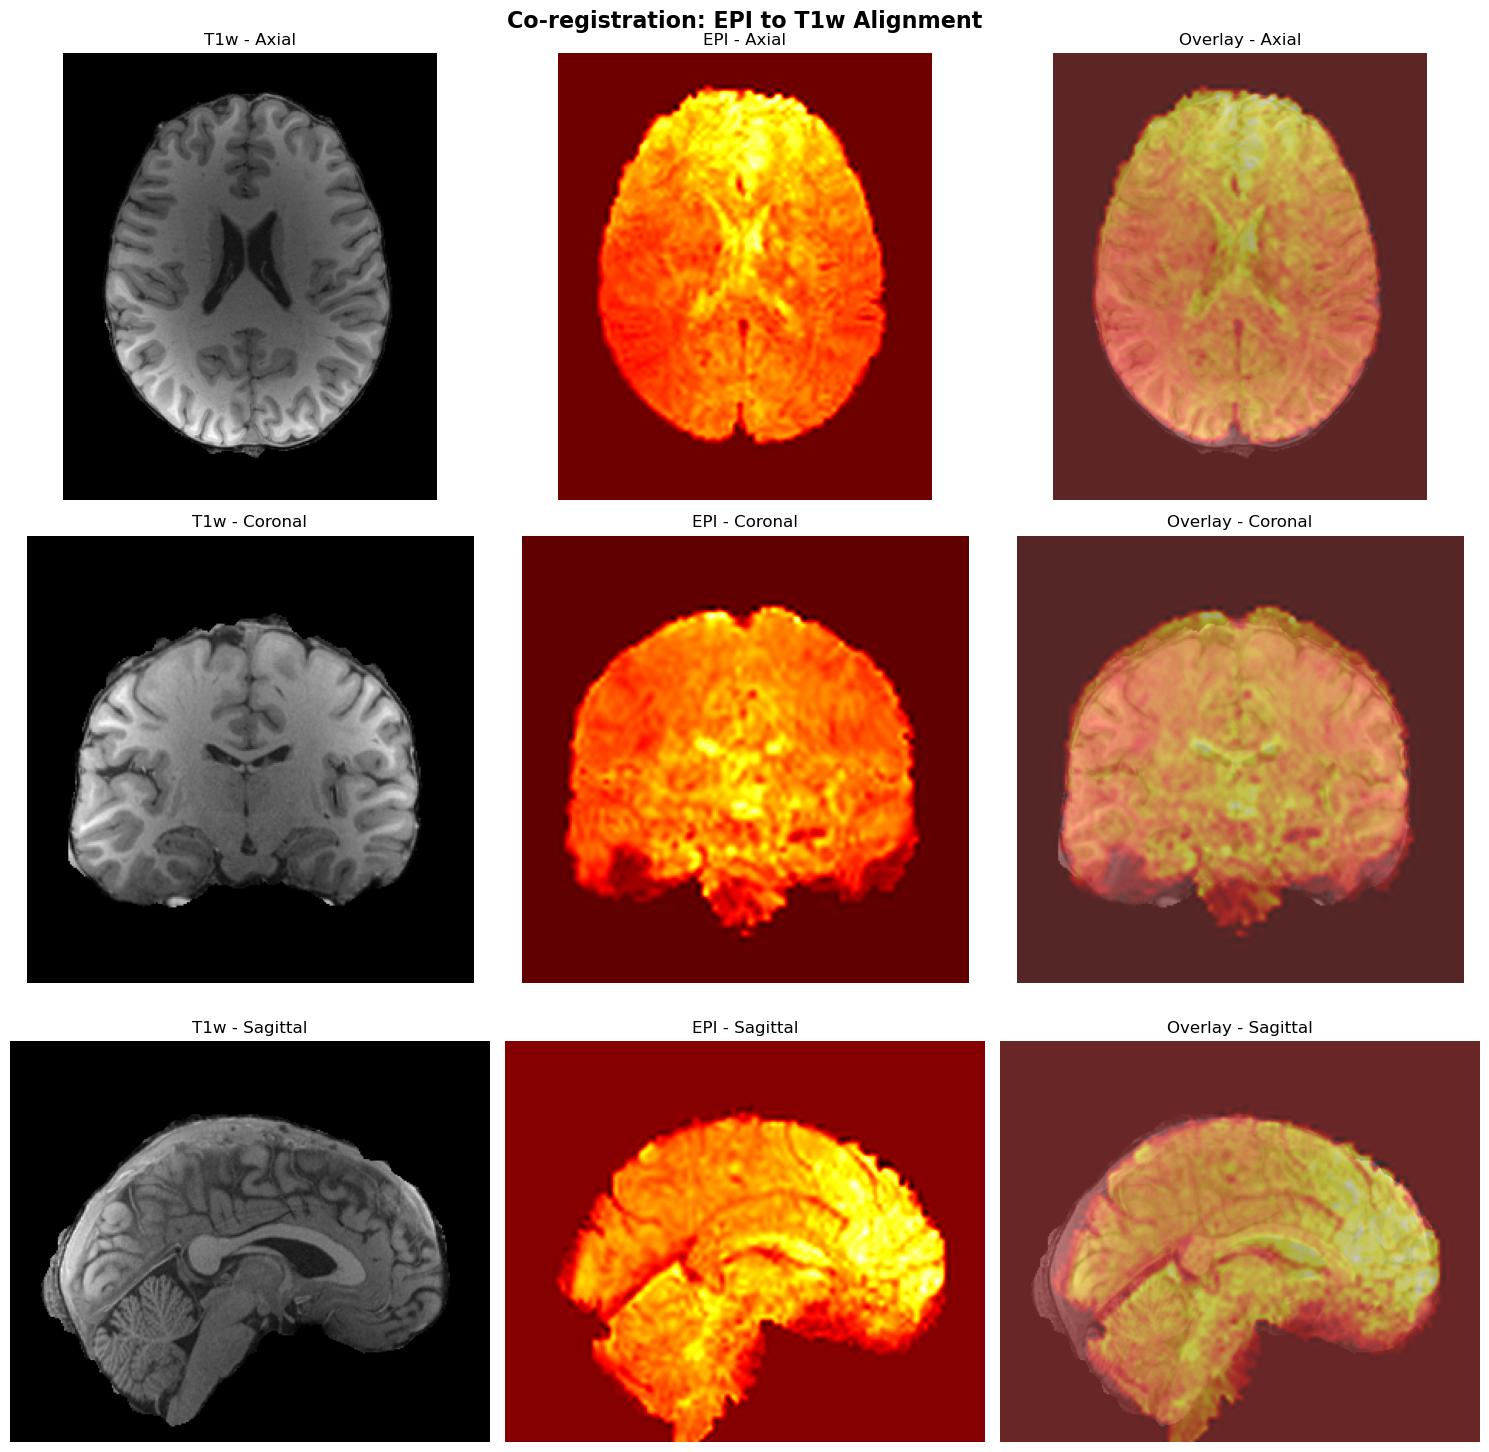

In [7]:

# Load images - check both possible locations
from config import BIDS_ROOT, SUBJECT_DIR

t1w_brain_deriv = os.path.join(DERIVATIVES_ROOT, "T1w_brain.nii.gz")
t1w_brain_raw = os.path.join(BIDS_ROOT, SUBJECT_DIR, "T1w", "T1w_brain.nii.gz")

if os.path.isfile(t1w_brain_deriv):
    t1w_brain_path = t1w_brain_deriv
elif os.path.isfile(t1w_brain_raw):
    t1w_brain_path = t1w_brain_raw
else:
    raise FileNotFoundError(
        f"T1w brain not found in {t1w_brain_deriv} or {t1w_brain_raw}"
    )

t1w_brain = load_image_safely(t1w_brain_path, "T1w brain (target)")

registered_epi = load_image_safely(
    os.path.join(COREG_DIR, "moco_vol_bbr.nii.gz"),
    "Registered EPI (source)"
)

# Extract middle slices for all three views
t1w_data = t1w_brain.get_fdata()
epi_data = registered_epi.get_fdata()

# Calculate middle slice indices
mid_x = t1w_data.shape[0] // 2  # Sagittal
mid_y = t1w_data.shape[1] // 2  # Coronal
mid_z = t1w_data.shape[2] // 2  # Axial

# Create figure with 3 rows (views) and 3 columns (T1w, EPI, Overlay)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Co-registration: EPI to T1w Alignment', fontsize=16, fontweight='bold')

# Row 0: Axial view (z-slice)
axes[0, 0].imshow(t1w_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0, 0].set_title('T1w - Axial', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(epi_data[:, :, mid_z].T, cmap='hot', origin='lower')
axes[0, 1].set_title('EPI - Axial', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(t1w_data[:, :, mid_z].T, cmap='gray', origin='lower', alpha=0.7)
axes[0, 2].imshow(epi_data[:, :, mid_z].T, cmap='hot', alpha=0.5, origin='lower')
axes[0, 2].set_title('Overlay - Axial', fontsize=12)
axes[0, 2].axis('off')

# Row 1: Coronal view (y-slice)
axes[1, 0].imshow(t1w_data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1, 0].set_title('T1w - Coronal', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(epi_data[:, mid_y, :].T, cmap='hot', origin='lower')
axes[1, 1].set_title('EPI - Coronal', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(t1w_data[:, mid_y, :].T, cmap='gray', origin='lower', alpha=0.7)
axes[1, 2].imshow(epi_data[:, mid_y, :].T, cmap='hot', alpha=0.5, origin='lower')
axes[1, 2].set_title('Overlay - Coronal', fontsize=12)
axes[1, 2].axis('off')

# Row 2: Sagittal view (x-slice)
axes[2, 0].imshow(t1w_data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2, 0].set_title('T1w - Sagittal', fontsize=12)
axes[2, 0].axis('off')

axes[2, 1].imshow(epi_data[mid_x, :, :].T, cmap='hot', origin='lower')
axes[2, 1].set_title('EPI - Sagittal', fontsize=12)
axes[2, 1].axis('off')

axes[2, 2].imshow(t1w_data[mid_x, :, :].T, cmap='gray', origin='lower', alpha=0.7)
axes[2, 2].imshow(epi_data[mid_x, :, :].T, cmap='hot', alpha=0.5, origin='lower')
axes[2, 2].set_title('Overlay - Sagittal', fontsize=12)
axes[2, 2].axis('off')

plt.tight_layout()

# Save figure
output_path = os.path.join(OUTPUT_ROOT, "figures", "coregistration.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Co-registration visualization saved to: {output_path}")
plt.show()

## 5. Gaussian Smoothing Visualization

Report the FSLeyes brain plot before and after this step.


Loaded Motion-corrected (before smoothing): /local_temp/pivron/Project/output/moco_mot_corr/moco.nii.gz (shape: (91, 109, 91, 568))
Loaded Smoothed (after smoothing): /local_temp/pivron/Project/output/smoothed/moco_smooth.nii.gz (shape: (91, 109, 91, 568))
Smoothing comparison saved to: /local_temp/pivron/Project/output/figures/smoothing_comparison.png


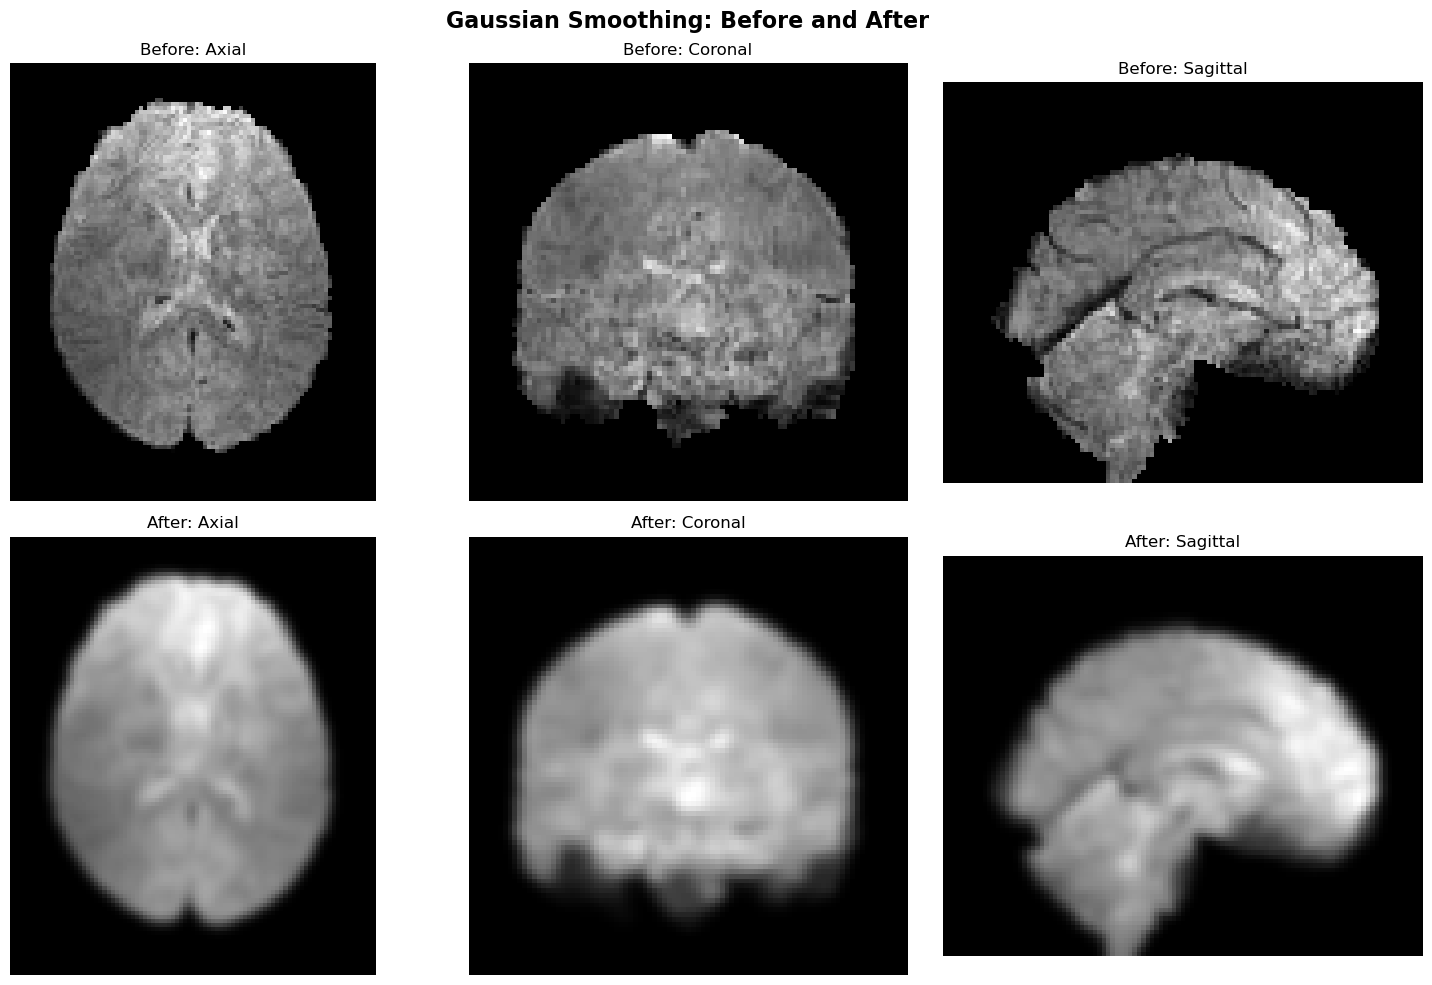

In [8]:
# Load images
moco_path = os.path.join(MOCO_DIR, "moco.nii.gz")
smooth_path = os.path.join(SMOOTH_DIR, "moco_smooth.nii.gz")

moco = load_image_safely(moco_path, "Motion-corrected (before smoothing)")
smooth = load_image_safely(smooth_path, "Smoothed (after smoothing)")

# Get shapes without loading full data
moco_shape = moco.shape
smooth_shape = smooth.shape

mid_z = moco_shape[2] // 2
mid_t = moco_shape[3] // 2
mid_y = moco_shape[1] // 2
mid_x = moco_shape[0] // 2

# Only load the specific volume we need (not the entire 4D dataset)
moco_vol = moco.slicer[:, :, :, mid_t]
moco_data = moco_vol.get_fdata()

smooth_vol = smooth.slicer[:, :, :, mid_t]
smooth_data = smooth_vol.get_fdata()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Gaussian Smoothing: Before and After', fontsize=16, fontweight='bold')

# Before smoothing - different views
axes[0, 0].imshow(moco_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Before: Axial')
axes[0, 0].axis('off')

axes[0, 1].imshow(moco_data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title('Before: Coronal')
axes[0, 1].axis('off')

axes[0, 2].imshow(moco_data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[0, 2].set_title('Before: Sagittal')
axes[0, 2].axis('off')

# After smoothing
axes[1, 0].imshow(smooth_data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[1, 0].set_title('After: Axial')
axes[1, 0].axis('off')

axes[1, 1].imshow(smooth_data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1, 1].set_title('After: Coronal')
axes[1, 1].axis('off')

axes[1, 2].imshow(smooth_data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[1, 2].set_title('After: Sagittal')
axes[1, 2].axis('off')

plt.tight_layout()

# Save figure
output_path = os.path.join(OUTPUT_ROOT, "figures", "smoothing_comparison.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Smoothing comparison saved to: {output_path}")
plt.show()

## Summary

All visualizations have been generated and saved to the `figures/` directory.

**Generated plots:**
- ✓ Skull stripping comparison
- ✓ Tissue segmentation
- ✓ Framewise displacement
- ✓ Co-registration overlay
- ✓ Gaussian smoothing comparison

All figures are saved in: `{OUTPUT_ROOT}/figures/`
